# Deconfounder on Jobs Data

### Author: Anya

Optimized functional code for deconfounder, using Jobs dataset. 

Deconfounder tutorial: https://colab.research.google.com/github/blei-lab/deconfounder_tutorial/blob/master/deconfounder_tutorial.ipynb#scrollTo=tYjfPtOW_zmc

Jobs Data: https://users.nber.org/~rdehejia/data/.nswdata2.html


#Setup

In [1]:
!pip install tensorflow_probability

In [4]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import numpy.random as npr
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.api as sm

from tensorflow_probability import edward2 as ed
from sklearn.datasets import load_breast_cancer
from pandas.plotting import scatter_matrix
from scipy import sparse, stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, mean_squared_error, r2_score
from sklearn.utils import shuffle

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

import seaborn as sns
color_names = ["windows blue",
               "amber",
               "crimson",
               "faded green",
               "dusty purple",
               "greyish"]
colors = sns.xkcd_palette(color_names)
sns.set(style="white", palette=sns.xkcd_palette(color_names), color_codes = False)

In [3]:
# set random seed so everyone gets the same number
import random
randseed = 123
print("random seed: ", randseed)
random.seed(randseed)
np.random.seed(randseed)
tf.set_random_seed(randseed)

random seed:  123


# Data Preprocessing

## Pull and Clean Jobs Data

Change necessary preprocessing steps/file paths according to the dataset being used.

**Jobs Data**: Upload the jobs text files to Coalb environment, or use appropriate file paths.

In [10]:
def txt_to_csv(txt_path, csv_path, column_list):
  """ Convert text files to readable CSV.
      Input: 
        txt_path: Path to text file
        csv_path: Path to CSV File
        column_list: List of header column values
      Output:
        Cleaned CSV stored at CSV Path
  """

  control = pd.read_csv(txt_path, delimiter = '  ', header= None)
  control.columns = column_list
  control.to_csv (csv_path, index=None)
  return control


def preprocess_jobs(control_txt, control_csv, treated_txt, treated_csv):
  
  """
  Convert Control and Treated text files to csv, concat them and return the merged dataset, X and Y values
  Input:
    Path to control/treated text/csv files, target column (prediction for regression or classification).
    TARGET COLUMN MUST BE THE LAST COLUMN.
  Output:
    Merged Data, X , Y
  """
  columns = ['treatment','age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're75', 're78']
  control = txt_to_csv(control_txt, control_csv, columns)
  treated = txt_to_csv(treated_txt, control_csv, columns)

  #merge treatement and control
  data = pd.concat([treated, control], ignore_index = True)
  data = shuffle(data).reset_index(drop=True)

  X = data[columns[:-1]]
  Y = data["re78"]
  
  return data, X, Y

In [40]:
data, df, dfY = preprocess_jobs('/content/nsw_control.txt', '/content/control.csv', '/content/nsw_treated.txt', '/content/treated.csv')

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [41]:
data

,treatment,age,education,black,hispanic,married,nodegree,re75,re78
0,1.0,20.0,6.0,0.0,1.0,1.0,1.0,10802.980,4488.495
1,0.0,26.0,8.0,1.0,0.0,0.0,1.0,5562.598,3523.578
2,0.0,18.0,9.0,0.0,0.0,0.0,1.0,559.596,7300.498
3,0.0,26.0,11.0,1.0,0.0,0.0,1.0,0.000,7176.187
4,1.0,21.0,11.0,0.0,1.0,0.0,1.0,1395.390,0.000
...,...,...,...,...,...,...,...,...,...
717,0.0,21.0,14.0,1.0,0.0,0.0,0.0,5926.795,29408.040
718,0.0,18.0,10.0,1.0,0.0,0.0,1.0,0.000,9602.439
719,0.0,45.0,9.0,1.0,0.0,0.0,1.0,0.000,4844.803
720,0.0,19.0,9.0,1.0,0.0,0.0,1.0,0.000,5712.643


In [42]:
df

,treatment,age,education,black,hispanic,married,nodegree,re75
0,1.0,20.0,6.0,0.0,1.0,1.0,1.0,10802.980
1,0.0,26.0,8.0,1.0,0.0,0.0,1.0,5562.598
2,0.0,18.0,9.0,0.0,0.0,0.0,1.0,559.596
3,0.0,26.0,11.0,1.0,0.0,0.0,1.0,0.000
4,1.0,21.0,11.0,0.0,1.0,0.0,1.0,1395.390
...,...,...,...,...,...,...,...,...
717,0.0,21.0,14.0,1.0,0.0,0.0,0.0,5926.795
718,0.0,18.0,10.0,1.0,0.0,0.0,1.0,0.000
719,0.0,45.0,9.0,1.0,0.0,0.0,1.0,0.000
720,0.0,19.0,9.0,1.0,0.0,0.0,1.0,0.000


In [43]:
dfY

0       4488.495
1       3523.578
2       7300.498
3       7176.187
4          0.000
         ...    
717    29408.040
718     9602.439
719     4844.803
720     5712.643
721    12573.970
Name: re78, Length: 722, dtype: float64

## Prepare Dataset for deconfounder

Get rid of highly correlated causes in order for the deconfounder to work

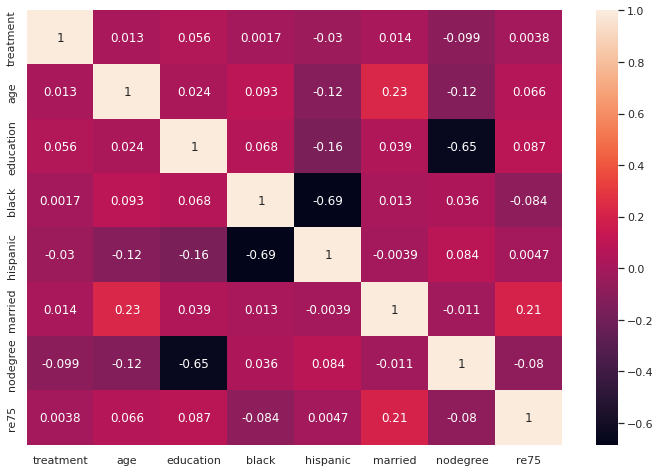

In [44]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True)

High negative correlation between nodegree and education (intuitive), as well as ethnicities of Black and hispanics (interesting). Removing nodegree and hispanic

In [45]:
def remove_correlated_features(df, column_list):
  "Remove the columns in column_list, return seperate df with dropped columns. Do not modify original"
  dfX = df.drop(column_list, axis = 1, inplace= False)
  return dfX

In [46]:
dfX = remove_correlated_features(df, ["nodegree", "hispanic"])

In [47]:
dfX

,treatment,age,education,black,married,re75
0,1.0,20.0,6.0,0.0,1.0,10802.980
1,0.0,26.0,8.0,1.0,0.0,5562.598
2,0.0,18.0,9.0,0.0,0.0,559.596
3,0.0,26.0,11.0,1.0,0.0,0.000
4,1.0,21.0,11.0,0.0,0.0,1395.390
...,...,...,...,...,...,...
717,0.0,21.0,14.0,1.0,0.0,5926.795
718,0.0,18.0,10.0,1.0,0.0,0.000
719,0.0,45.0,9.0,1.0,0.0,0.000
720,0.0,19.0,9.0,1.0,0.0,0.000


# Causal Inference with Decoder

## Optional: Normalize data

In [98]:
def normalize(df, normalized_columns):
  "Normalize the data. Default is no normalization, specify the (non-binary) columns to be normalized if necessary. "
  df_copy =  df.copy()
  if normalized_columns:
    df_copy[normalized_columns] = df_copy[normalized_columns].apply(lambda x: (x - x.mean()) / (x.std()))
  return df_copy

In [99]:
df

,treatment,age,education,black,hispanic,married,nodegree,re75
0,1.0,20.0,6.0,0.0,1.0,1.0,1.0,10802.980
1,0.0,26.0,8.0,1.0,0.0,0.0,1.0,5562.598
2,0.0,18.0,9.0,0.0,0.0,0.0,1.0,559.596
3,0.0,26.0,11.0,1.0,0.0,0.0,1.0,0.000
4,1.0,21.0,11.0,0.0,1.0,0.0,1.0,1395.390
...,...,...,...,...,...,...,...,...
717,0.0,21.0,14.0,1.0,0.0,0.0,0.0,5926.795
718,0.0,18.0,10.0,1.0,0.0,0.0,1.0,0.000
719,0.0,45.0,9.0,1.0,0.0,0.0,1.0,0.000
720,0.0,19.0,9.0,1.0,0.0,0.0,1.0,0.000


In [102]:
#X = normalize(df, ["age","education","re75"])
X = normalize(dfX,[])

In [103]:
X

,treatment,age,education,black,married,re75
0,1.0,20.0,6.0,0.0,1.0,10802.980
1,0.0,26.0,8.0,1.0,0.0,5562.598
2,0.0,18.0,9.0,0.0,0.0,559.596
3,0.0,26.0,11.0,1.0,0.0,0.000
4,1.0,21.0,11.0,0.0,0.0,1395.390
...,...,...,...,...,...,...
717,0.0,21.0,14.0,1.0,0.0,5926.795
718,0.0,18.0,10.0,1.0,0.0,0.000
719,0.0,45.0,9.0,1.0,0.0,0.000
720,0.0,19.0,9.0,1.0,0.0,0.000


## Holdout Random Entries

In [104]:
# randomly holdout some entries of X
num_datapoints, data_dim = X.shape

holdout_portion = 0.2
n_holdout = int(holdout_portion * num_datapoints * data_dim)

holdout_row = np.random.randint(num_datapoints, size=n_holdout)
holdout_col = np.random.randint(data_dim, size=n_holdout)
holdout_mask = (sparse.coo_matrix((np.ones(n_holdout), \
                            (holdout_row, holdout_col)), \
                            shape = X.shape)).toarray()

holdout_subjects = np.unique(holdout_row)
holdout_mask = np.minimum(1, holdout_mask)

x_train = np.multiply(1-holdout_mask, X)
x_vad = np.multiply(holdout_mask, X)


## Probabilistic PCA

In [105]:
#select model, either linear or quadratic
form = "quadratic"

In [106]:
# we allow both linear and quadratic model
# for linear model x_n has mean z_n * W
# for quadratic model x_n has mean b + z_n * W + (z_n**2) * W_2
# quadractice model needs to change the checking step accordingly

def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints, mask, form="linear"):
    w = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                scale=tf.ones([latent_dim, data_dim]),
                name="w")  # parameter
    z = ed.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                scale=tf.ones([num_datapoints, latent_dim]), 
                name="z")  # local latent variable / substitute confounder
    if form == "linear":
        x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), mask),
                    scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                    name="x")  # (modeled) data
    elif form == "quadratic":
        b = ed.Normal(loc=tf.zeros([1, data_dim]),
                scale=tf.ones([1, data_dim]),
                name="b")  # intercept
        w2 = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                scale=tf.ones([latent_dim, data_dim]),
                name="w2")  # quadratic parameter
        x = ed.Normal(loc=tf.multiply(b + tf.matmul(z, w) + tf.matmul(tf.square(z), w2), mask),
                    scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                    name="x")  # (modeled) data
    return x, (w, z)

log_joint = ed.make_log_joint_fn(ppca_model)

In [107]:
# fitting PPCA

latent_dim = 2
stddv_datapoints = 0.1

model = ppca_model(data_dim=data_dim,
                   latent_dim=latent_dim,
                   num_datapoints=num_datapoints,
                   stddv_datapoints=stddv_datapoints, 
                   mask=1-holdout_mask,
                   #change form according to experiment
                   form = form)

Inferred axes:
[[ 4.6157047e-02  3.7360370e+00  1.4776691e+00  1.1736588e-01
   2.1331586e-02  3.7295765e+01]
 [-4.9571183e-02 -2.9881468e+00 -1.1515591e+00 -9.6972205e-02
  -1.6775962e-02  3.7292328e+01]]
Standard Deviation:
[[1.2384134e-03 3.7363023e-03 2.0015461e-03 8.7246974e-04 8.4626616e-04
  1.4483206e+00]
 [1.5279297e-03 5.5059926e-03 2.3563735e-03 5.6262873e-04 9.7203680e-04
  1.2785633e-01]]


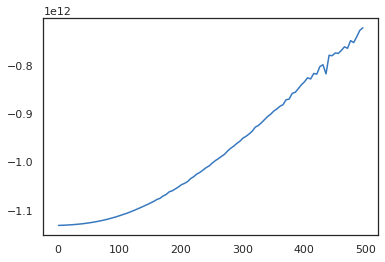

In [108]:
def variational_model(qb_mean, qb_stddv, qw_mean, qw_stddv, 
                      qw2_mean, qw2_stddv, qz_mean, qz_stddv):
    qb = ed.Normal(loc=qb_mean, scale=qb_stddv, name="qb")
    qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
    qw2 = ed.Normal(loc=qw2_mean, scale=qw2_stddv, name="qw2")
    qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
    return qb, qw, qw2, qz


log_q = ed.make_log_joint_fn(variational_model)

def target(b, w, w2, z):
    """Unnormalized target density as a function of the parameters."""
    return log_joint(data_dim=data_dim,
                   latent_dim=latent_dim,
                   num_datapoints=num_datapoints,
                   stddv_datapoints=stddv_datapoints,
                   mask=1-holdout_mask,
                   w=w, z=z, w2=w2, b=b, x=x_train)

def target_q(qb, qw, qw2, qz):
    return log_q(qb_mean=qb_mean, qb_stddv=qb_stddv,
                 qw_mean=qw_mean, qw_stddv=qw_stddv,
                 qw2_mean=qw2_mean, qw2_stddv=qw2_stddv,
                 qz_mean=qz_mean, qz_stddv=qz_stddv,
                 qw=qw, qz=qz, qw2=qw2, qb=qb)

qb_mean = tf.Variable(np.ones([1, data_dim]), dtype=tf.float32)
qw_mean = tf.Variable(np.ones([latent_dim, data_dim]), dtype=tf.float32)
qw2_mean = tf.Variable(np.ones([latent_dim, data_dim]), dtype=tf.float32)
qz_mean = tf.Variable(np.ones([num_datapoints, latent_dim]), dtype=tf.float32)
qb_stddv = tf.nn.softplus(tf.Variable(0 * np.ones([1, data_dim]), dtype=tf.float32))
qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, data_dim]), dtype=tf.float32))
qw2_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, data_dim]), dtype=tf.float32))
qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([num_datapoints, latent_dim]), dtype=tf.float32))

qb, qw, qw2, qz = variational_model(qb_mean=qb_mean, qb_stddv=qb_stddv,
                                    qw_mean=qw_mean, qw_stddv=qw_stddv,
                                    qw2_mean=qw2_mean, qw2_stddv=qw2_stddv,
                                    qz_mean=qz_mean, qz_stddv=qz_stddv)


energy = target(qb, qw, qw2, qz)
entropy = -target_q(qb, qw, qw2, qz)

elbo = energy + entropy


optimizer = tf.train.AdamOptimizer(learning_rate = 0.05)
train = optimizer.minimize(-elbo)

init = tf.global_variables_initializer()

t = []

num_epochs = 500

with tf.Session() as sess:
    sess.run(init)

    for i in range(num_epochs):
        sess.run(train)
        if i % 5 == 0:
            t.append(sess.run([elbo]))

        b_mean_inferred = sess.run(qb_mean)
        b_stddv_inferred = sess.run(qb_stddv)
        w_mean_inferred = sess.run(qw_mean)
        w_stddv_inferred = sess.run(qw_stddv)
        w2_mean_inferred = sess.run(qw2_mean)
        w2_stddv_inferred = sess.run(qw2_stddv)
        z_mean_inferred = sess.run(qz_mean)
        z_stddv_inferred = sess.run(qz_stddv)
        
print("Inferred axes:")
print(w_mean_inferred)
print("Standard Deviation:")
print(w_stddv_inferred)

plt.plot(range(1, num_epochs, 5), t)
plt.show()

def replace_latents(b, w, w2, z):

    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        """Replaces the priors with actual values to generate samples from."""
        name = rv_kwargs.pop("name")
        if name == "b":
            rv_kwargs["value"] = b
        elif name == "w":
            rv_kwargs["value"] = w
        elif name == "w":
            rv_kwargs["value"] = w2
        elif name == "z":
            rv_kwargs["value"] = z
        return rv_constructor(*rv_args, **rv_kwargs)

    return interceptor

## Check Factor Model

In [109]:
n_rep = 100 # number of replicated datasets we generate
holdout_gen = np.zeros((n_rep,*(x_train.shape)))

for i in range(n_rep):
    b_sample = npr.normal(b_mean_inferred, b_stddv_inferred)
    w_sample = npr.normal(w_mean_inferred, w_stddv_inferred)
    w2_sample = npr.normal(w2_mean_inferred, w2_stddv_inferred)
    z_sample = npr.normal(z_mean_inferred, z_stddv_inferred)

    with ed.interception(replace_latents(b_sample, w_sample, w2_sample, z_sample)):
        generate = ppca_model(
            data_dim=data_dim, latent_dim=latent_dim,
            num_datapoints=num_datapoints, stddv_datapoints=stddv_datapoints,
            mask=np.ones(x_train.shape),
            #change according to experiment
            form = form)

    with tf.Session() as sess:
        x_generated, _ = sess.run(generate)

    # look only at the heldout entries
    holdout_gen[i] = np.multiply(x_generated, holdout_mask)

In [110]:
n_eval = 100 # we draw samples from the inferred Z and W
obs_ll = []
rep_ll = []



for j in range(n_eval):
  if form == "linear":
    w_sample = npr.normal(w_mean_inferred, w_stddv_inferred)
    z_sample = npr.normal(z_mean_inferred, z_stddv_inferred)

    holdoutmean_sample = np.multiply(z_sample.dot(w_sample), holdout_mask)

  if form == "quadratic":
    b_sample = npr.normal(b_mean_inferred, b_stddv_inferred)
    w_sample = npr.normal(w_mean_inferred, w_stddv_inferred)
    w2_sample = npr.normal(w2_mean_inferred, w2_stddv_inferred)
    z_sample = npr.normal(z_mean_inferred, z_stddv_inferred)

    holdoutmean_sample = np.multiply(b_sample + z_sample.dot(w_sample) + np.square(z_sample).dot(w2_sample), holdout_mask)



  obs_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                        stddv_datapoints).logpdf(x_vad), axis=1))

  rep_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                        stddv_datapoints).logpdf(holdout_gen),axis=2))
    
obs_ll_per_zi, rep_ll_per_zi = np.mean(np.array(obs_ll), axis=0), np.mean(np.array(rep_ll), axis=0)





In [111]:
pvals = np.array([np.mean(rep_ll_per_zi[:,i] < obs_ll_per_zi[i]) for i in range(num_datapoints)])
holdout_subjects = np.unique(holdout_row)
overall_pval = np.mean(pvals[holdout_subjects])

print("Predictive check p-values", overall_pval)

Predictive check p-values 0.4971968190854871


## Correct for Substitute confounder

In [112]:
# approximate the (random variable) substitute confounders with their inferred mean.
Z_hat = z_mean_inferred 
# augment the regressors to be both the assigned causes X and the substitute confounder Z
X_aug = np.column_stack([X, Z_hat])
# holdout some data from prediction later
X_train, X_test, y_train, y_test = train_test_split(X_aug, dfY, test_size=0.2, random_state=0)

In [113]:
  #add constant term 
dcfX_train = sm.add_constant(X_train)

## change logit from referrence to OLS for regressin (instead of classification)
# dcflogit_model = sm.Logit(y_train, dcfX_train)
# dcfresult = dcflogit_model.fit_regularized(maxiter=5000)

dcfOLS_model = sm.OLS(y_train, dcfX_train)
dcfresult = dcfOLS_model.fit()
print(dcfresult.summary())
#dcfresult = dcfOLS_model.fit_regularized(maxiter=5000)

#summary when regularized is null for some reason, print params : https://github.com/statsmodels/statsmodels/issues/3670
#print(dcfresult.params)


                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3.734
Date:                Wed, 13 Apr 2022   Prob (F-statistic):           0.000284
Time:                        19:52:22   Log-Likelihood:                -5850.5
No. Observations:                 577   AIC:                         1.172e+04
Df Residuals:                     568   BIC:                         1.176e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2579.3641   1855.865      1.390      0.1

In [114]:
#correct tutorials dfresult.conv_int

res = pd.DataFrame({"causal_mean": dcfresult.params[:data_dim+1], \
                    "causal_std": dcfresult.bse[:data_dim+1], \
                    "causal_025": dcfresult.conf_int()[:data_dim+1][0], \
                    "causal_975": dcfresult.conf_int()[:data_dim+1][1], \
                   "causal_pval": dcfresult.pvalues[:data_dim+1]
                  })

res["causal_sig"] = (res["causal_pval"] < 0.05)
res = res.T
res.columns = np.concatenate([["intercept"], np.array(dfX.columns)])
res = res.T

In [116]:
# make predictions with the causal model 
dcfX_test = X_test
dcfy_pred = dcfresult.predict(sm.add_constant(dcfX_test))
print(r2_score(y_test, dcfy_pred))



-0.0030264887917115235


In [119]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
regressor.fit( X_train,y_train)

y_pred = regressor.predict(X_test)
print(r2_score(y_test, y_pred))

-0.36674764326736886
